In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
data = pd.read_csv("/Users/evangray/Desktop/Projects/prosperity/prosperity-3/Data Logs/Round 3/d3dab92a-3183-4454-add8-b614e497477d.csv", delimiter=";")

In [8]:
squid_df = data[data["product"] == "SQUID_INK"].reset_index()

In [15]:
mean = 3
squid_df[f"mean_{mean}"] = squid_df["mid_price"].rolling(window=3).mean()
squid_df[f"std_{mean}"] = squid_df["mid_price"].rolling(window=3).std()

In [16]:
squid_df[f"std_{mean}"]

0           NaN
1           NaN
2      1.154701
3      0.000000
4      0.577350
         ...   
995    0.866025
996    0.288675
997    0.288675
998    0.288675
999    0.763763
Name: std_3, Length: 1000, dtype: float64

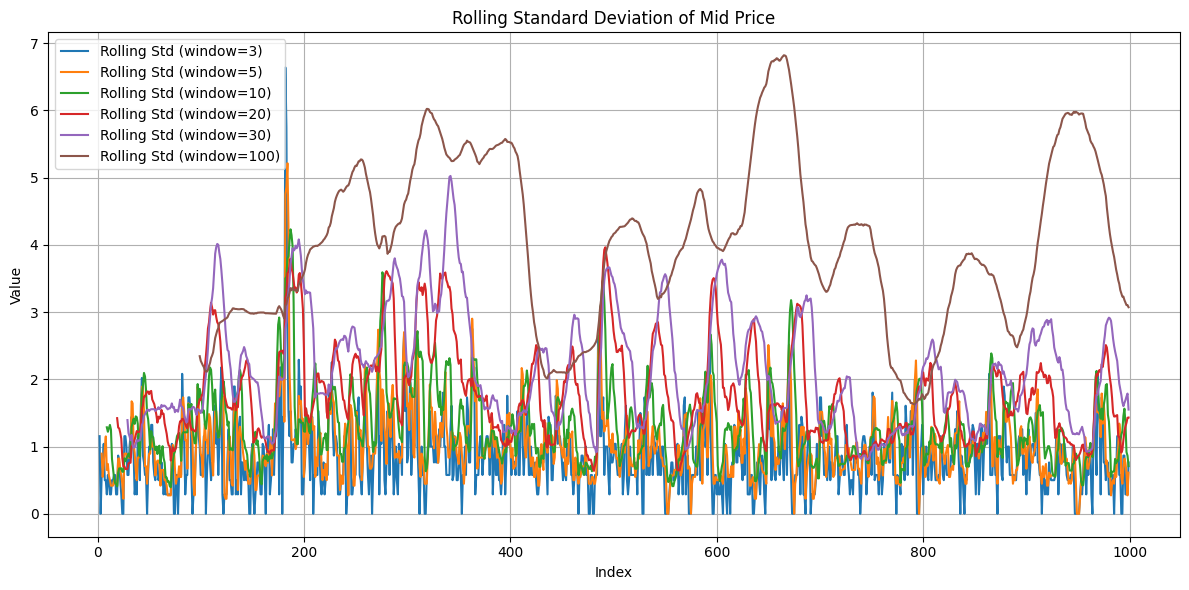

In [23]:
import pandas as pd
import matplotlib.pyplot as plt

# Example window sizes
window_sizes = [3, 5, 10, 20, 30, 100]

# Calculate rolling standard deviation for each window size
for window in window_sizes:
    squid_df[f"std_{window}"] = squid_df["mid_price"].rolling(window=window).std()

# Plot original and rolling stds
plt.figure(figsize=(12, 6))
# plt.plot(squid_df["mid_price"], label='Mid Price', linewidth=2)

for window in window_sizes:
    plt.plot(squid_df[f"std_{window}"], label=f"Rolling Std (window={window})")

plt.title("Rolling Standard Deviation of Mid Price")
plt.xlabel("Index")
plt.ylabel("Value")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


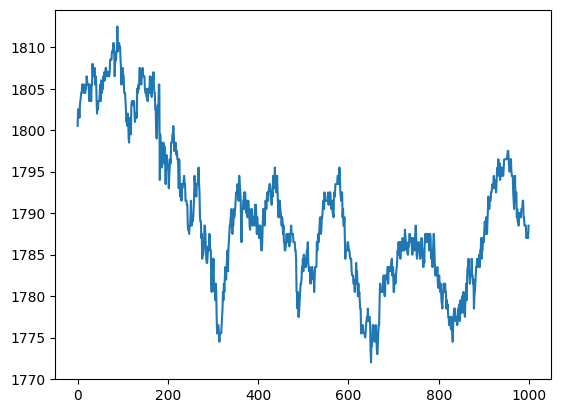

In [21]:
plt.plot(squid_df.mid_price)

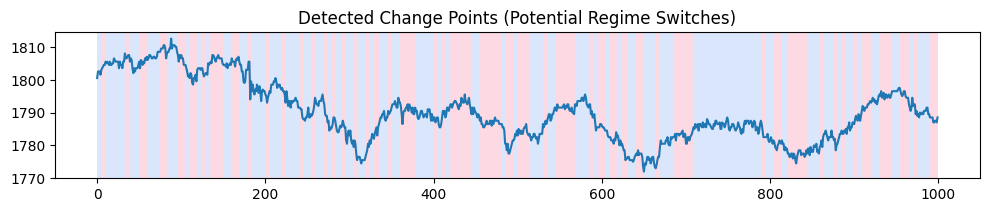

Pocket lengths: [ 5 25  5 10 10 15 10 10 10  5 10  5  5  5 15 10 10 10  5 15  5 15  5 15
  5 10  5 10  5  5  5  5  5 10  5 10  5  5  5 10  5 10 20 20  5  5  5  5
 25 10 25  5 10  5 15 15  5 10 25 15  5  5 10  5 10  5  5 10 10 15  5 15
 25 80  5 10 10  5 25 15  5 10  5  5  5 10  5  5 10 10 15 10 10  5  5 15
 10]
Mean duration: 10.257731958762887
Std duration: 9.006616526073568


In [40]:
from ruptures import Binseg

signal = squid_df['mid_price'].dropna().values
algo = Binseg(model="l2").fit(signal)
change_points = algo.predict(n_bkps=97)  # Change this to tune sensitivity

# Plot the change points
import ruptures as rpt
rpt.display(signal, change_points)
plt.title("Detected Change Points (Potential Regime Switches)")
plt.show()

change_points = algo.predict(n_bkps=97) 
pocket_lengths = np.diff(change_points)
print("Pocket lengths:", pocket_lengths)
print("Mean duration:", np.mean(pocket_lengths))
print("Std duration:", np.std(pocket_lengths))


In [36]:
stds = []
means = []
for i in range(2, 100):
    change_points = algo.predict(n_bkps=i) 
    pocket_lengths = np.diff(change_points)
    means.append(np.mean(pocket_lengths))
    stds.append(np.std(pocket_lengths))
# print("Pocket lengths:", pocket_lengths)
# print("Mean duration:", np.mean(pocket_lengths))
# print("Std duration:", np.std(pocket_lengths))

In [38]:
np.argmin(stds)

97

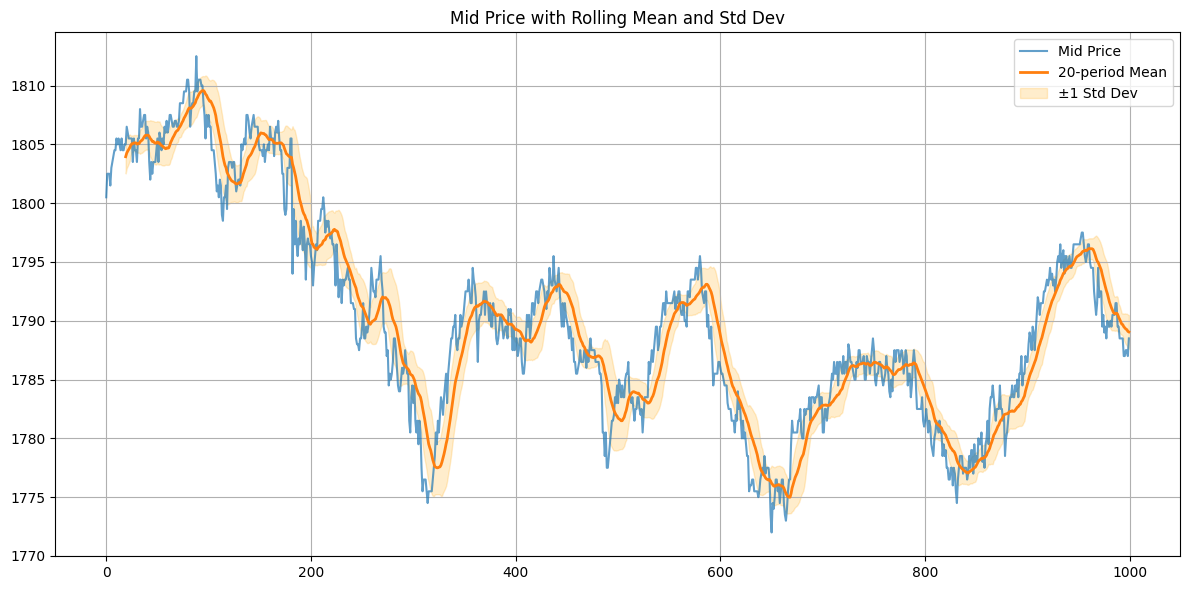

In [26]:
import matplotlib.pyplot as plt

window = 20
squid_df['rolling_mean'] = squid_df['mid_price'].rolling(window).mean()
squid_df['rolling_std'] = squid_df['mid_price'].rolling(window).std()

plt.figure(figsize=(12, 6))
plt.plot(squid_df['mid_price'], label='Mid Price', alpha=0.7)
plt.plot(squid_df['rolling_mean'], label=f'{window}-period Mean', linewidth=2)
plt.fill_between(squid_df.index,
                 squid_df['rolling_mean'] - squid_df['rolling_std'],
                 squid_df['rolling_mean'] + squid_df['rolling_std'],
                 color='orange', alpha=0.2, label='±1 Std Dev')
plt.title("Mid Price with Rolling Mean and Std Dev")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [44]:
pb1_df = data[data["product"] == "PICNIC_BASKET1"].reset_index()
pb2_df = data[data["product"] == "PICNIC_BASKET2"].reset_index()
croissants_df = data[data["product"] == "CROISSANTS"].reset_index()
jams_df = data[data["product"] == "JAMS"].reset_index()
djembes_df = data[data["product"] == "DJEMBES"].reset_index()

In [46]:
pb1_df.columns

Index(['index', 'day', 'timestamp', 'product', 'bid_price_1', 'bid_volume_1',
       'bid_price_2', 'bid_volume_2', 'bid_price_3', 'bid_volume_3',
       'ask_price_1', 'ask_volume_1', 'ask_price_2', 'ask_volume_2',
       'ask_price_3', 'ask_volume_3', 'mid_price', 'profit_and_loss'],
      dtype='object')

`PICNIC_BASKET1`
1. Six (6) `CROISSANTS`
2. Three (3) `JAMS`
3. One (1) `DJEMBES`

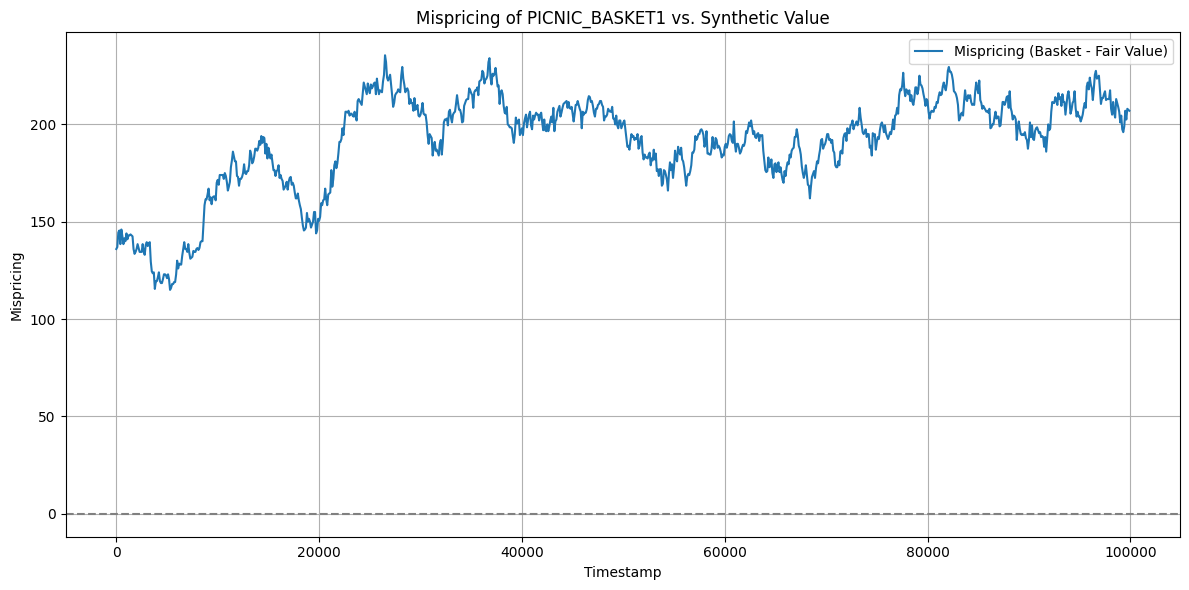

In [47]:
import pandas as pd

# Assume `df` is your full DataFrame
# Step 1: Pivot or split by product
pivoted = data.pivot(index='timestamp', columns='product', values='mid_price')

# Step 2: Rename for easier access (optional)
pivoted.columns.name = None  # remove 'product' name
pivoted = pivoted.rename(columns={
    'CROISSANTS': 'croissants',
    'JAMS': 'jams',
    'DJEMBES': 'djembes',
    'PICNIC_BASKET1': 'basket'
})

# Step 3: Compute fair value
pivoted['fair_value'] = (
    6 * pivoted['croissants'] +
    3 * pivoted['jams'] +
    1 * pivoted['djembes']
)

# Step 4: Compute mispricing
pivoted['mispricing'] = pivoted['basket'] - pivoted['fair_value']
pivoted['relative_mispricing_pct'] = pivoted['mispricing'] / pivoted['fair_value']

# Step 5: Identify over/under valuation
pivoted['status'] = pivoted['mispricing'].apply(
    lambda x: 'overvalued' if x > 0 else 'undervalued' if x < 0 else 'fair'
)

# View the result
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 6))
plt.plot(pivoted.index, pivoted['mispricing'], label='Mispricing (Basket - Fair Value)')
plt.axhline(0, color='gray', linestyle='--')
plt.title("Mispricing of PICNIC_BASKET1 vs. Synthetic Value")
plt.xlabel("Timestamp")
plt.ylabel("Mispricing")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [49]:
pivoted

,croissants,djembes,jams,KELP,basket,PICNIC_BASKET2,RAINFOREST_RESIN,SQUID_INK,VOLCANIC_ROCK,VOLCANIC_ROCK_VOUCHER_10000,VOLCANIC_ROCK_VOUCHER_10250,VOLCANIC_ROCK_VOUCHER_10500,VOLCANIC_ROCK_VOUCHER_9500,VOLCANIC_ROCK_VOUCHER_9750,fair_value,mispricing,relative_mispricing_pct,status
timestamp,,,,,,,,,,,,,,,,,,
0,4265.5,13419.5,6519.5,2045.5,58707.0,30096.5,10000.0,1800.5,10218.5,233.5,63.5,8.5,718.5,469.5,58571.0,136.0,0.002322,overvalued
100,4265.5,13419.5,6520.0,2046.5,58709.5,30096.5,10000.0,1802.5,10217.5,234.5,62.5,8.5,718.0,469.0,58572.5,137.0,0.002339,overvalued
200,4265.5,13419.5,6519.5,2045.5,58715.5,30095.0,10000.0,1802.5,10222.0,235.5,64.5,9.5,722.5,473.5,58571.0,144.5,0.002467,overvalued
300,4265.5,13419.5,6519.5,2045.5,58716.5,30095.5,10000.0,1802.5,10223.0,235.5,65.5,9.5,723.5,474.5,58571.0,145.5,0.002484,overvalued
400,4266.5,13419.5,6519.5,2045.5,58715.5,30099.5,10000.0,1801.5,10217.0,234.5,62.5,8.5,717.5,468.5,58577.0,138.5,0.002364,overvalued
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99500,4264.0,13480.5,6544.0,2050.5,58903.5,30107.0,10000.0,1787.0,10154.5,181.5,39.5,4.5,654.5,406.5,58696.5,207.0,0.003527,overvalued
99600,4264.5,13480.5,6543.5,2051.0,58900.5,30104.5,10000.0,1787.5,10154.0,176.5,39.5,4.5,654.5,406.5,58698.0,202.5,0.003450,overvalued
99700,4264.0,13480.5,6544.0,2051.5,58904.5,30104.0,10000.0,1787.5,10150.5,176.5,38.5,4.5,650.5,403.0,58696.5,208.0,0.003544,overvalued


`PICNIC_BASKET2`
1. Four (4) `CROISSANTS`
2. Two (2) `JAMS`

In [45]:
djembes_df

,index,day,timestamp,product,bid_price_1,bid_volume_1,bid_price_2,bid_volume_2,bid_price_3,bid_volume_3,ask_price_1,ask_volume_1,ask_price_2,ask_volume_2,ask_price_3,ask_volume_3,mid_price,profit_and_loss
0,8,2,0,DJEMBES,13419.0,72.0,NaN,NaN,NaN,NaN,13420,72,NaN,NaN,NaN,NaN,13419.5,0.0
1,16,2,100,DJEMBES,13419.0,20.0,13418.0,37.0,NaN,NaN,13420,57,NaN,NaN,NaN,NaN,13419.5,0.0
2,32,2,200,DJEMBES,13419.0,25.0,13418.0,42.0,NaN,NaN,13420,67,NaN,NaN,NaN,NaN,13419.5,0.0
3,55,2,300,DJEMBES,13419.0,64.0,NaN,NaN,NaN,NaN,13420,64,NaN,NaN,NaN,NaN,13419.5,0.0
4,60,2,400,DJEMBES,13419.0,68.0,NaN,NaN,NaN,NaN,13420,21,13421.0,47.0,NaN,NaN,13419.5,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,13930,2,99500,DJEMBES,13480.0,61.0,NaN,NaN,NaN,NaN,13481,61,NaN,NaN,NaN,NaN,13480.5,0.0
996,13953,2,99600,DJEMBES,13480.0,66.0,NaN,NaN,NaN,NaN,13481,60,NaN,NaN,NaN,NaN,13480.5,0.0
997,13961,2,99700,DJEMBES,13480.0,75.0,NaN,NaN,NaN,NaN,13481,28,13482.0,47.0,NaN,NaN,13480.5,0.0
998,13973,2,99800,DJEMBES,13479.0,55.0,NaN,NaN,NaN,NaN,13481,55,NaN,NaN,NaN,NaN,13480.0,0.0


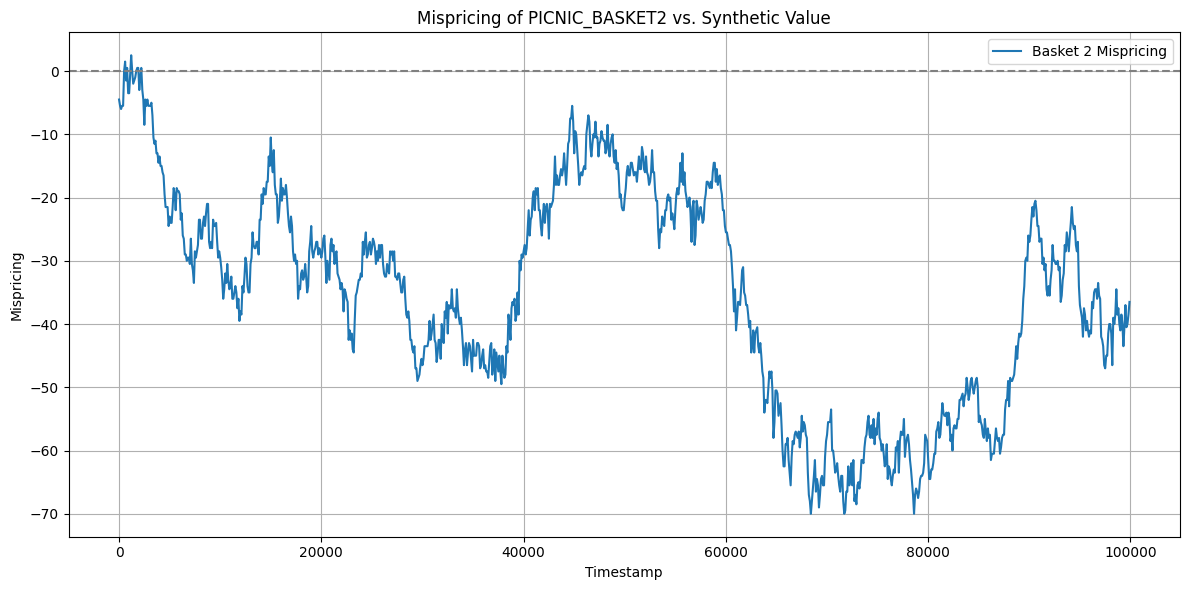

In [50]:
import pandas as pd
import matplotlib.pyplot as plt

# Assume df is your main DataFrame
pivoted = data.pivot(index='timestamp', columns='product', values='mid_price')
pivoted.columns.name = None
pivoted = pivoted.rename(columns={
    'CROISSANTS': 'croissants',
    'JAMS': 'jams',
    'DJEMBES': 'djembes',
    'PICNIC_BASKET1': 'basket1',
    'PICNIC_BASKET2': 'basket2'
})

# Fair value calculations
pivoted['fair_value_basket1'] = 6 * pivoted['croissants'] + 3 * pivoted['jams'] + 1 * pivoted['djembes']
pivoted['fair_value_basket2'] = 4 * pivoted['croissants'] + 2 * pivoted['jams']

# Mispricing
pivoted['mispricing_basket1'] = pivoted['basket1'] - pivoted['fair_value_basket1']
pivoted['mispricing_basket2'] = pivoted['basket2'] - pivoted['fair_value_basket2']

pivoted['status_basket1'] = pivoted['mispricing_basket1'].apply(
    lambda x: 'overvalued' if x > 0 else 'undervalued' if x < 0 else 'fair'
)

pivoted['status_basket2'] = pivoted['mispricing_basket2'].apply(
    lambda x: 'overvalued' if x > 0 else 'undervalued' if x < 0 else 'fair'
)

# Plot for Basket 2
plt.figure(figsize=(12, 6))
plt.plot(pivoted.index, pivoted['mispricing_basket2'], label='Basket 2 Mispricing')
plt.axhline(0, color='gray', linestyle='--')
plt.title("Mispricing of PICNIC_BASKET2 vs. Synthetic Value")
plt.xlabel("Timestamp")
plt.ylabel("Mispricing")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [52]:
pivoted['status_basket2']

timestamp
0        undervalued
100      undervalued
200      undervalued
300      undervalued
400      undervalued
            ...     
99500    undervalued
99600    undervalued
99700    undervalued
99800    undervalued
99900    undervalued
Name: status_basket2, Length: 1000, dtype: object

In [53]:
import numpy as np
import pandas as pd

# Parameters
n_turtles = 1000
reserves = np.random.normal(loc=200, scale=50, size=n_turtles)
reserves = np.clip(reserves, 100, 300)  # keep within realistic range

# Simulate a range of first and second bid strategies
first_bids = np.arange(200, 260, 10)  # First bid strategies
second_bids = np.arange(240, 300, 10)  # Second bid strategies

# Simulate global average of second bids
global_second_bid_averages = np.arange(240, 280, 10)

# Result storage
results = []

for avg_second_bid in global_second_bid_averages:
    for fbid in first_bids:
        for sbid in second_bids:
            # First bid: Turtles accept if bid > reserve
            first_wins = reserves < fbid
            first_profit = np.sum(320 - fbid) * np.mean(first_wins)

            # Second bid: Turtles accept if bid > reserve and bid > global avg
            second_wins = (reserves < sbid) & (sbid > avg_second_bid)
            second_profit = np.sum(320 - sbid) * np.mean(second_wins)

            total_profit = first_profit + second_profit

            results.append({
                "First_Bid": fbid,
                "Second_Bid": sbid,
                "Global_Avg_Second_Bid": avg_second_bid,
                "First_Profit": first_profit,
                "Second_Profit": second_profit,
                "Total_Profit": total_profit,
                "First_Accepted": np.mean(first_wins),
                "Second_Accepted": np.mean(second_wins)
            })

results_df = pd.DataFrame(results)

In [60]:
results_df.head(15)

,First_Bid,Second_Bid,Global_Avg_Second_Bid,First_Profit,Second_Profit,Total_Profit,First_Accepted,Second_Accepted
0,200,240,240,57.12,0.00,57.12,0.476,0.000
1,200,250,240,57.12,57.61,114.73,0.476,0.823
2,200,260,240,57.12,52.14,109.26,0.476,0.869
3,200,270,240,57.12,45.45,102.57,0.476,0.909
4,200,280,240,57.12,37.60,94.72,0.476,0.940
5,200,290,240,57.12,28.77,85.89,0.476,0.959
6,210,240,240,62.26,0.00,62.26,0.566,0.000
7,210,250,240,62.26,57.61,119.87,0.566,0.823
8,210,260,240,62.26,52.14,114.40,0.566,0.869
9,210,270,240,62.26,45.45,107.71,0.566,0.909


In [59]:
np.argmax(results_df["Total_Profit"])

13

In [61]:
from scipy.stats import norm
from scipy.optimize import minimize

# Define the expected profit function
def expected_profit_bid_vector(bids, mu_r=200, sigma_r=50, mu=250, P_s=320):
    B1, B2 = bids
    # Ensure bid bounds
    if not (100 <= B1 <= 300 and 100 <= B2 <= 320):
        return -1e6  # Penalize out-of-bound values
    F1 = norm.cdf(B1, loc=mu_r, scale=sigma_r)
    F2 = norm.cdf(B2, loc=mu_r, scale=sigma_r) if B2 > mu else 0
    profit = F1 * (P_s - B1) + F2 * (P_s - B2)
    return -profit  # Minimize negative profit

# Initial guess
initial_guess = [220, 260]

# Bounds for the bids
bounds = [(100, 300), (100, 320)]

# Run optimization
result = minimize(expected_profit_bid_vector, x0=initial_guess, bounds=bounds)

# Get optimal bids and profit
optimal_B1, optimal_B2 = result.x
max_profit = -result.fun

(optimal_B1, optimal_B2, max_profit)

(220.81771830561865, 250.00638109213276, 124.49344128720705)

In [64]:
from scipy.optimize import minimize_scalar

# Updated reserve distribution: Uniform(160–200) and Uniform(250–320)
def custom_reserve_cdf(bid):
    if bid < 160:
        return 0
    elif 160 <= bid <= 200:
        return (bid - 160) / 80 * 0.5  # First half of distribution (50% mass)
    elif 200 < bid < 250:
        return 0.5  # No turtles in this range
    elif 250 <= bid <= 320:
        return 0.5 + (bid - 250) / 70 * 0.5  # Second half of distribution
    else:
        return 1

# Vectorized CDF function
custom_cdf = np.vectorize(custom_reserve_cdf)

# Adjusted expected profit function
def expected_profit_bid_vector_updated(bids, avg_bid=260, P_s=320):
    B1, B2 = bids
    # Out-of-bounds penalty
    if not (160 <= B1 <= 320 and 160 <= B2 <= 320):
        return -1e6
    
    F1 = custom_reserve_cdf(B1)
    F2 = custom_reserve_cdf(B2)

    profit1 = F1 * (P_s - B1)

    # For B2 < avg_bid, scale profit using penalty formula
    if B2 < avg_bid:
        p = ((P_s - avg_bid) / (P_s - B2)) ** 3
        profit2 = F2 * (P_s - B2) * p
    else:
        profit2 = F2 * (P_s - B2)

    return -(profit1 + profit2)  # Minimize negative profit

# Optimization
initial_guess = [210, 260]
bounds = [(160, 320), (160, 320)]

result_updated = minimize(expected_profit_bid_vector_updated, x0=initial_guess, bounds=bounds)

# Extract results
optimal_B1_updated, optimal_B2_updated = result_updated.x
max_profit_updated = -result_updated.fun

(optimal_B1_updated, optimal_B2_updated, max_profit_updated)


(200.0383356265941, 259.6096380521234, 93.83385472423282)

In [66]:
# Test multiple average bid assumptions for the second bid penalty
average_bid_range = np.arange(250, 280, 2)
experiment_results = []

for avg_bid in average_bid_range:
    result = minimize(
        expected_profit_bid_vector_updated,
        x0=[200, 260],
        bounds=[(160, 320), (160, 320)],
        args=(avg_bid,)
    )
    optimal_B1, optimal_B2 = result.x
    max_profit = -result.fun

    experiment_results.append({
        "Average_Second_Bid": avg_bid,
        "Optimal_B1": optimal_B1,
        "Optimal_B2": optimal_B2,
        "Expected_Profit": max_profit
    })

experiment_df = pd.DataFrame(experiment_results)


In [67]:
experiment_df

,Average_Second_Bid,Optimal_B1,Optimal_B2,Expected_Profit
0,250,200.000008,260.0,94.285710
1,252,200.000008,260.0,94.285710
2,254,200.000008,260.0,94.285710
3,256,200.000008,260.0,94.285710
4,258,200.000008,260.0,94.285710
5,260,200.000008,260.0,94.285710
6,262,200.000008,260.0,90.970159
7,264,200.000008,260.0,87.875556
8,266,200.000008,260.0,54.994435
9,268,200.000008,260.0,82.318747


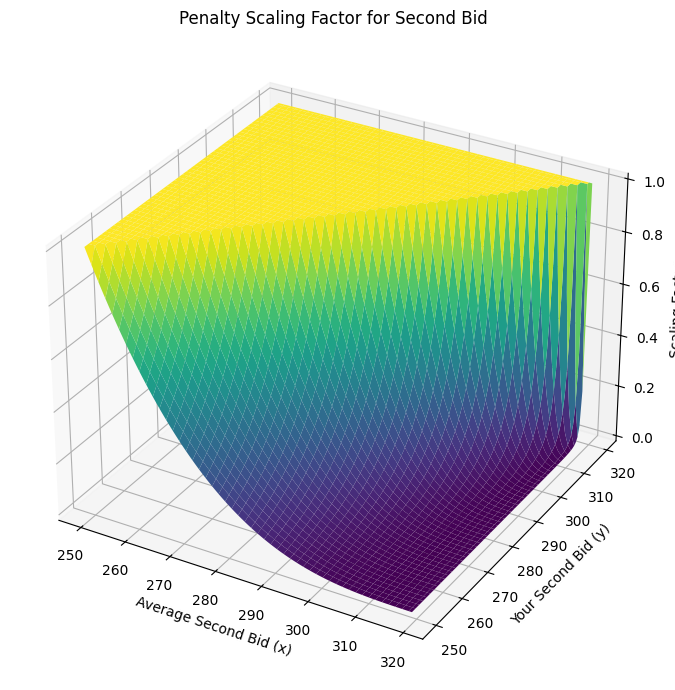

In [68]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Create meshgrid for x (average bid) and y (your bid)
x = np.linspace(250, 319, 100)  # average bid
y = np.linspace(250, 319, 100)  # your bid

X, Y = np.meshgrid(x, y)

# Compute penalty scaling factor
Z = ((320 - X) / (320 - Y)) ** 3
Z[Y >= X] = 1  # When your bid >= average bid, no penalty

# Plotting
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X, Y, Z, cmap='viridis')

ax.set_title("Penalty Scaling Factor for Second Bid")
ax.set_xlabel("Average Second Bid (x)")
ax.set_ylabel("Your Second Bid (y)")
ax.set_zlabel("Scaling Factor p")

plt.tight_layout()
plt.show()
